# Machine Learning with Panel Data 

A. Jung, 2023
(alex.jung@aalto.fi)

# Time Series Data

The code snippet below reads in wind speed measurments from the file "Kuopio_Savilahti.csv" which is stored in the GitHub repository "https://raw.githubusercontent.com/alexjungaalto/ResearchPublic/master/paneldata"

In [ ]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf

import warnings
warnings.filterwarnings('ignore')

wind_data_dir="https://raw.githubusercontent.com/alexjungaalto/ResearchPublic/master/paneldata"
dmy_cntr=0

stations_Fin = pd.read_csv('https://raw.githubusercontent.com/alexjungaalto/ResearchPublic/master/paneldata/FMIcoords.csv')

for index, row in stations_Fin.iterrows():
    if index==100: 
        print(row["station"])
        fullfile = os.path.join(wind_data_dir, row["station"]+".csv")
        print(fullfile)
        weather_df = pd.read_csv(fullfile)
        timeseries = weather_df.iloc[:,5].replace("-",0).to_numpy(dtype=float)
      #  plt.plot(np.arange(len(timeseries)), timeseries.reshape(-1,1))
        break

timesegment = timeseries.reshape(-1,1)
duration = len(timesegment)

print(weather_df.head(5))

print("average wind speed: ",np.mean(timesegment))
print("maximum wind speed: ",np.max(timesegment))
print("minimum wind speed: ",np.min(timesegment))
tmpsig = weather_df.iloc[:,5].replace("-",0).to_numpy(dtype=float)

The code snippet below creates a plot of the wind speed measurements and another plot for the partial autocorrelation function of the time series constituted by the wind speed measurements. 

In [ ]:
fig, axs = plt.subplots(1,figsize=(20,10))
axs.tick_params(axis='both', which='major', labelsize=30)
#markerline, stemline, baseline, =axs.stem(np.arange(duration),timesegment[:duration] ,basefmt=" ")
axs.plot(np.arange(duration),timesegment[:duration] )
axs.set_xlabel('time instant t',fontsize=23)
axs.set_ylabel('wind speed [m/s]',fontsize=23)
#plt.setp(markerline, markersize = 15)

fig, axs = plt.subplots(1,figsize=(20,10))
markerline, stemline, baseline, = axs.stem(pacf(timeseries), basefmt=" ")
axs.tick_params(axis='both', which='major', labelsize=30)
axs.set_ylabel('partial autocorrelation',fontsize=23)
axs.set_xlabel('lag',fontsize=23)
plt.setp(markerline, markersize = 15)

In [ ]:
def extractXyfromtimeseries(timeseries,nrfeatures,horizon):
    """calculate the distance between two different stations"""
    # first we insert nrfeatures zeros in the beginning and 
    # forecasting horizon zeros at the end. horizon=0 means next time step forecasting
    
    paddedtimeseries = np.vstack([np.zeros((nrfeatures,1)),np.copy(timeseries.reshape(-1,1)),np.zeros((horizon,1))])
    X = np.empty((0,nrfeatures), float)
    y = np.empty((0,1), float)
    for iter_time in range(len(timeseries)): 
        X = np.append(X, paddedtimeseries[iter_time:(iter_time+nrfeatures)].reshape(1,-1), axis=0)
        y = np.append(y,paddedtimeseries[nrfeatures+horizon+iter_time].reshape(1,-1),axis=0)
        
    return X,y

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

fig, axs = plt.subplots(1,figsize=(10,5))
duration = 600
horizon=0
nrfeatures=1
X,y = extractXyfromtimeseries(timeseries,nrfeatures,horizon)
reg = RandomForestRegressor(max_depth=200, random_state=0).fit(X, y)
forecast = reg.predict(X)

axs.plot(np.arange(duration-horizon),timeseries[horizon:(duration)],label="wind speed" )
axs.plot(np.arange(duration-horizon),forecast[0:(duration-horizon)],label="forecast" )
axs.set_xlabel('time instant t',fontsize=23)
axs.set_ylabel('wind speed [m/s]',fontsize=23)
plt.title("horizon ="+str(horizon)+", nrfeatures="+str(nrfeatures))
axs.legend()
print(np.mean(y))

# Networked Data and Models - The Empirical Graph

Many important application domains, ranging from the internet of things to high-precision management of pandemics, generate collections of local datasets that are related by some network structure. We can conveniently represent such networked data by an undirected weighted graph, which we refer to as an empirical graph. The nodes of the  empirical graph, carry local datasets which are related by undirected edges that reflect pair-wise similarities.

The Python package `networkx` provides convenient means for storing and manipulating networked data and models. We will demonstrate how to generate and process an empirical graph using the class `networkx.Graph` and its methods. 

# Exercise - Finnish Weather Data

Generate a networkx graph `G_FMI` whose nodes represent FMI weather stations for which observations are stored in the file 

https://raw.githubusercontent.com/alexjungaalto/ResearchPublic/master/paneldata/FMIcoords.csv

Assign each node of the graph `G_FMI` the following attributes

* 'name' which is the station name 
* 'coords' which is a numpy array of shape (1,2) that contains latitute and longitue of station 
* 'wind' which contains the wind speed time series from the corresponding csv file

In [89]:
import random
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import datetime as dt
import networkx as nx

In [90]:

# read in raw data which has been downloaded from FMI 
stations_Fin = pd.read_csv('https://raw.githubusercontent.com/alexjungaalto/ResearchPublic/master/paneldata/FMIcoords.csv')
num_stations = stations_Fin.shape[0]

In [91]:
import math


# this function computes the approximate geodesic distance between two 
# FMI stations based on their latitude and longitude coordinats. 

def get_dist(graph,nodeA,nodeB):
    """calculate the distance between two different stations"""
    coord_1 = graph.nodes[nodeA]['coord']
    coord_2 = graph.nodes[nodeB]['coord']
    
    radius = 6371  # km

    dlat = math.radians(coord_2[0] - coord_1[0])
    dlon = math.radians(coord_2[1] - coord_1[1])
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(coord_1[0])) * math.cos(math.radians(coord_2[0])) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d


# this function iterates over all FMI stations and adds a link to the its 
# nearest neighbours (whose number is determiend by the parameter `total_neigh`)

def add_edges(graph,total_neigh=4):
    num_nodes = graph.number_of_nodes()
    for i in range(num_nodes):
            node_dists = []
            '''
            a list containing the distance between node i and other nodes of the graph
            '''
            for j in range(num_nodes):
                if j == i:
                    continue
                node_dists.append(get_dist(graph,i, j))

            # sort node_dists in order to pick the nearest nodes to the node i 
            node_dists.sort(reverse=False)
            node_cnt = 0
            for j in range(num_nodes):

                if node_cnt >= total_neigh:
                    break

                if j == i:
                    continue

                # calculate the distance between node i and j of the graph
                dist = get_dist(graph,i, j)
                if dist == 0 or dist > node_dists[total_neigh]:
                    continue
                node_cnt += 1
                graph.add_edge(i, j)
    return graph

In [92]:
G_FMI = nx.Graph()
G_FMI.add_nodes_from(range(0,num_stations))
# add node attributes: station name,feature, and label


for  iter_station, row in stations_Fin.iterrows():
    # first filter out rows in dataframe data with attribution `station` equal to the
    # current value of station 
    fullfile = os.path.join(wind_data_dir, row["station"]+".csv")
    G_FMI.nodes[iter_station]['name'] = row["station"]   
   # print(row["station"])
    # store the lat and lon of the current station in the node attribute `coord`
    G_FMI.nodes[iter_station]['coord'] = np.array([row.latitude,row.longitude]) # coordinates of i-th weather station  
    try: 
         weather_df = pd.read_csv(fullfile)
    except:
          timeseries = np.zeros((1000,1)) 
    else:
          timeseries = weather_df.iloc[:,5].replace("-",0).to_numpy(dtype=float)
    G_FMI.nodes[iter_station]['wind'] = timeseries
    X,y = extractXyfromtimeseries(timeseries,nrfeatures,horizon)
    G_FMI.nodes[iter_station]['X'] = X
    G_FMI.nodes[iter_station]['y'] = y
    #timeseries = weather_df.iloc[:,5].replace("-",0).to_numpy(dtype=float)


#for iter_station in range(5): 
#     timeseries = G_FMI.nodes[iter_station]['wind']
#     fig, axs = plt.subplots(1,figsize=(5,2))
#     axs.plot(np.arange(len(timeseries)), timeseries.reshape(-1,1))
#     plt.show()
# add edges between nodes (FMI stations) if they are nearest neighbours

G_FMI = add_edges(G_FMI,total_neigh=5)

Next produce a scatter plot that depicts each FMI station by a filled circle whose horizontal and vertical coordinates are, respectively, the longitutde and latitate of the FMI station. Draw a link between two FMI stations if their nodes are connected by an edge in the empirical graph `G_FMI`. 


<function matplotlib.pyplot.show(close=None, block=None)>

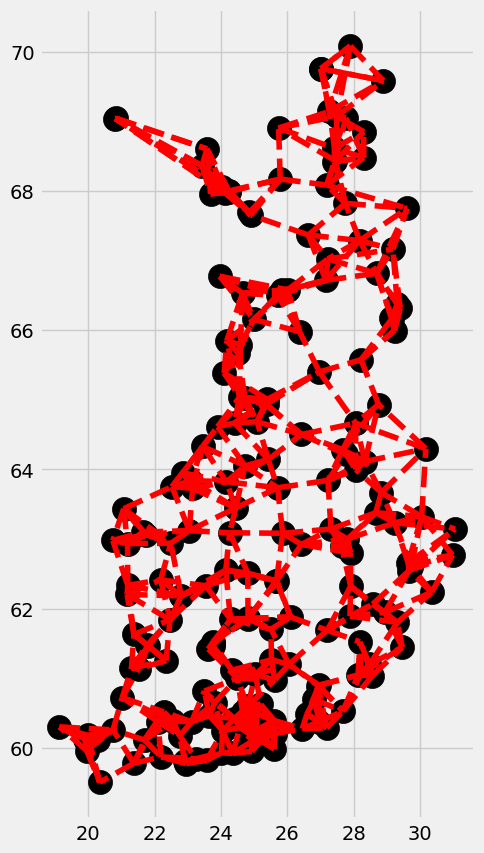

In [93]:
x = np.zeros(len(G_FMI.nodes)) 
y = np.zeros(len(G_FMI.nodes))

# collect the lat and long corrdinates of FMI stations in the numpy arrays x and y
for iter_node in G_FMI.nodes:
    # use latitude of FMI station as horizontal coordinate in the scatter plot 
    y[iter_node]= G_FMI.nodes[iter_node]['coord'][0] 
    # use longitude of FMI station as vertical coordinate in the scatter plot
    x[iter_node]= G_FMI.nodes[iter_node]['coord'][1]
    

# create a figure with prescribed dimensions 
fig, ax = plt.subplots(figsize=(5,10))
# generate a scatter plot with each marker representing an FMI station
ax.scatter(x, y, 300, marker='o', color='Black')
# draw links between two FMI stations if they are connected by an edge 
# in the empirical graph 
for edge_dmy in G_FMI.edges:
    ax.plot([x[edge_dmy[0]],x[edge_dmy[1]]],[y[edge_dmy[0]],y[edge_dmy[1]]],'r--',lw=4)

#for iter_node in G_FMI.nodes : 
   # ax.annotate("   "+str(min(G_FMI.nodes[iter_node]['X'])[0]), (x[iter_node], y[iter_node]))
plt.show

## Clustering Assumption

In what follows, we use k-means clustering to pool local datasets for similar FMI stations. The clustering will be based two features for each FMI station: 
* x1 = the average wind speed 
* x2 = the maximum wind speed 
* x3 = the minimum wind speed

Use k-means with k=2 clusters. 


In [105]:
from sklearn.cluster import KMeans
from sklearn import cluster, mixture

nrclusters = 3
tmp_X = np.zeros((len(G_FMI.nodes),2))

# loop over all nodes 
for iter_node in G_FMI.nodes: 
    tmp_X[iter_node,:] = np.array([np.mean(G_FMI.nodes[iter_node]["wind"]),np.max(G_FMI.nodes[iter_node]["wind"])])
   # print(tmp_X[iter_node,:])

# fit a Gaussian mixture model to the feature vectors of FMI Stations
gmm = mixture.GaussianMixture(nrclusters).fit(tmp_X)
# the fitted GMM can be used to calculate degree of belonging to clusters for each FMI station
softdob0 = gmm.predict_proba(tmp_X)[:,0]
# run k-means hard clustering on feature vectors of FMI stations
kmeans = KMeans(n_clusters=nrclusters, random_state=0).fit(tmp_X)

clusterassgt=kmeans.predict(tmp_X)

The above clustering was based solely on the features of each FMI station. Alternatively, we can cluster FMI stations based on the edge structure of the empirical graph. Graph clustering methods allow to partition nodes of the empirical graph solely based on their network structure. 

In [106]:
import networkx.algorithms.community as nx_comm

cluster_list = nx_comm.louvain_communities(G_FMI, resolution=0.1,seed=123)

# comment the following if you want to use above clustering
#nrclusters = len (cluster_list)

#clusterassgt=np.zeros((len(G_FMI.nodes()),)).astype('int')
#for iter_cluster in range(nrclusters): 
#    for iter_node in cluster_list[iter_cluster]:
#        clusterassgt[iter_node]=iter_cluster

The following code snippet generates a scatter plot of FMI stations. Each station is represented by a marker with identical colour if they FMI station belong to the same cluster obtained from k-means. 

<function matplotlib.pyplot.show(close=None, block=None)>

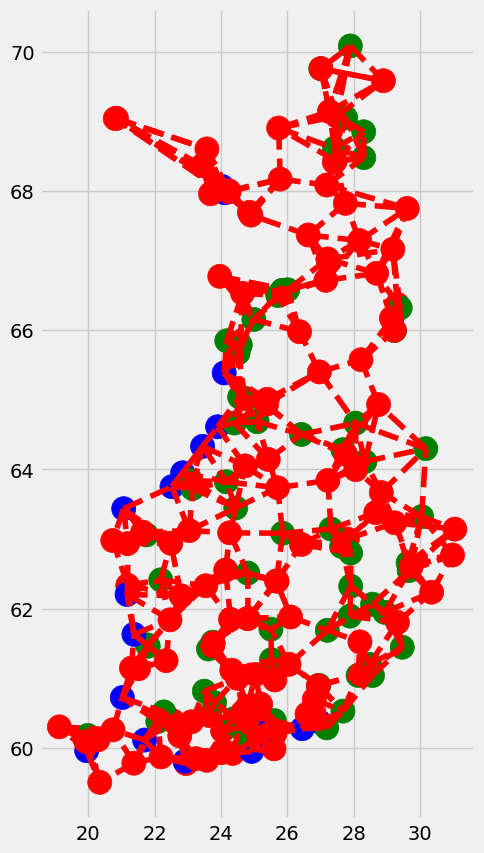

In [107]:
# create a dictionary with keys being the clustering index 0,1.. and 
# values the name of the colour to be used for the marker of FMI stations 
# in the corresponding cluster 

colors = {0:'red', 1:'green', 2:'blue', 3:'orange'}



# collect the lat and long corrdinates of FMI stations in the numpy arrays x and y
# collect the marker colour in the list "markercolors". The i-th entry of this list determines 
# the marker color for the i-th FMI station 

x = np.zeros(len(G_FMI.nodes)) 
y = np.zeros(len(G_FMI.nodes))
markercolors = []

for iter_node in G_FMI.nodes:
    # use latitude of FMI station as horizontal coordinate in the scatter plot 
    y[iter_node]= G_FMI.nodes[iter_node]['coord'][0] 
    # use longitude of FMI station as vertical coordinate in the scatter plot
    x[iter_node]= G_FMI.nodes[iter_node]['coord'][1]
    # append the color for the marker of the current station. the color is determined 
    # based on the clsuter assignment obtained from k-means
    markercolors.append(colors[clusterassgt[iter_node]])

fig, ax = plt.subplots(figsize=(5,10))
# generate a scatter plot with each marker representing an FMI station
#ax.scatter(x, y, 300, marker='o', c=softdob0,cmap='viridis')#markercolors)
ax.scatter(x, y, 300, marker='o', c=markercolors)
# draw links between two FMI stations if they are connected by an edge 
# in the empirical graph 
for edge_dmy in G_FMI.edges:
    ax.plot([x[edge_dmy[0]],x[edge_dmy[1]]],[y[edge_dmy[0]],y[edge_dmy[1]]],'r--',lw=4)
#for iter_node in G_FMI.nodes : 
#    ax.annotate(G_FMI.nodes[iter_node]['name'], (x[iter_node], y[iter_node]))
plt.show



# Cluster-Wise Training

In what follows we pool the local datasets of FMI stations in the same cluster to obtain a large training set to train a linear regression model. 

In [ ]:
# generate an empty dictionary with keys being the cluster indices c=0,1. We will use 
# this dictionary to store the trained models for each cluster

clustermodel= dict.fromkeys(range(0, nrclusters))

# generate an empty dictionary with keys being the cluster indices c=0,1. We will use 
# this dictionary to store features of the nodes in the same cluster 

clusterfeatures = dict.fromkeys(range(0, nrclusters))

# generate an empty dictionary with keys being the cluster indices c=0,1. We will use 
# this dictionary to store labels of the nodes in the same cluster 

clusterlabels = dict.fromkeys(range(0, nrclusters))

In [ ]:
# generat

# loop over all cluster indices c=0,1... 

for c in range(nrclusters): 
# collect nodes of FMI graph that belong to cluster c 

    selected_nodes = [n for n in G_FMI.nodes(data=False) if clusterassgt[n] == c]

    print("cluster "+str(c)+" contains "+str(len(selected_nodes))+" FMI stations ")
# create a numpy array that contains the features of the nodes in cluster c 

    X_cluster = np.empty((0,nrfeatures), float)

    for dmy in selected_nodes:
        X_cluster  = np.append(X_cluster, G_FMI.nodes[dmy]['X'], axis=0) 
    
    
    # replance any missing feature values with 0 

   # X_cluster[np.isnan(X_cluster)] = 0
    
    # store the resulting feature matrix in a dictionay 
    
    clusterfeatures[c] = X_cluster
    
    # create a numpy array contins the labels of the nodes in cluster 0 

    y_cluster = np.empty((0,1), float)

    for dmy in selected_nodes:
        y_cluster  = np.append(y_cluster, G_FMI.nodes[dmy]['y'], axis=0) 
    
    # replance any missing label values with 0 

  #  y_cluster[np.isnan(y_cluster)] = 0
    
    # store the stacked labels for the cluster in a dictionay 
    
    clusterlabels[c] = y_cluster
    
    # train a linear regression model for cluster c

    clustermodel[c] =LinearRegression().fit(X_cluster,y_cluster)


Generate a figure for each cluster c=0,1.., which contain a scatter plot of the pooled local datasets in this cluster. Each figure should also include a plot of the trained linear model for that cluster. 

In [ ]:
fig, axs = plt.subplots(nrclusters,figsize=(10,17))
plt.style.use('fivethirtyeight')

# scatter plot pooled data from cluster 0 and fitted model 
for clusteridx in range(nrclusters):
    axs[clusteridx].scatter(clusterfeatures[clusteridx], clusterlabels[clusteridx], color="black")
    axs[clusteridx].plot(clusterfeatures[clusteridx], clustermodel[clusteridx].predict(clusterfeatures[clusteridx]), color="blue", linewidth=3)
   # axs[clusteridx].legend(loc='upper left')
    axs[clusteridx].set_title("cluster "+str(clusteridx))
    axs[clusteridx].set_xlabel("feature $x_1$")
    axs[clusteridx].set_ylabel("label $y$")
    
plt.tight_layout(pad=3.0)
plt.show()
